In [1]:
import argparse

import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from lateral_connections import LateralModel, VggModel
from lateral_connections import VggWithLCL
from lateral_connections import MNISTCDataset
from lateral_connections.loaders import get_loaders, load_mnistc
from lateral_connections.character_models import SmallVggWithLCL, VGGReconstructionLCL
from lateral_connections.torch_utils import *

import datetime

In [2]:
vggonly_modelpath = 'models/vgg_with_lcl/VGG19_2022-04-04_183636__it16250_e3.pt'
vgg19r_lcl5_modelpath = 'models/vgg_reconstructed_lcl/2022-04-19_194505_LCL5_d2__it11250_e2.pt'

config = {
    'vggonly': {
        'num_classes': 10,
        'learning_rate': 1e-3,
        'dropout': 0.2,
        'num_epochs': 4,
        'batch_size': 10,
        'use_lcl': True,
        'num_multiplex': 4,
        'lcl_alpha': 1e-3,
        'lcl_theta': 0.2,
        'lcl_eta': 0.0,
        'lcl_iota': 0.2
    },
    'vgg19r_lcl5': {
        'num_classes': 10,
        'learning_rate': 3e-4,
        'num_multiplex': 4,
        'batch_size': 10,
        'num_epochs': 5,
        'lcl_alpha': 3e-4,
        'lcl_eta': 0.01,
        'lcl_theta': 0.2,
        'lcl_iota': 0.2,
        'lcl_distance': 2,
        'lcl_k': 5,
        'after_pooling': 5
    }
}

def load_vgg19r_lcl5(config, model_path):
    # Only load to initialize reconstruction
    vgg = VggWithLCL(config['num_classes'], learning_rate=3e-4, dropout=0.2)
    # generate & load weights for reconstructed model
    model = VGGReconstructionLCL(vgg,
                                 learning_rate=config['learning_rate'],
                                 after_pooling=config['after_pooling'],
                                 num_multiplex=config['num_multiplex'],
                                 run_identifier='',
                                 lcl_distance=config['lcl_distance'],
                                 lcl_alpha=config['lcl_alpha'],
                                 lcl_eta=config['lcl_eta'],
                                 lcl_theta=config['lcl_theta'],
                                 lcl_iota=config['lcl_iota'])
    model.load(model_path)
    model.features.lcl.enable()
    del vgg
    return model

def load_vgg19(config, model_path):
    model = VggWithLCL(config['num_classes'], \
                       learning_rate=config['learning_rate'], \
                       dropout=config['dropout'], \
                       num_multiplex=config['num_multiplex'], \
                       do_wandb=False, \
                       run_identifier="", \
                       lcl_alpha=config['lcl_alpha'], \
                       lcl_eta=config['lcl_eta'], \
                       lcl_theta=config['lcl_theta'], \
                       lcl_iota=config['lcl_iota'])
    model.load(model_path)
    return model

In [3]:
vgg19r_lcl5 = load_vgg19r_lcl5(config['vgg19r_lcl5'], vgg19r_lcl5_modelpath)
vgg19r_lcl5

VGGReconstructionLCL(
  (features): Sequential(
    (vgg19_unit): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(i

In [4]:
#vgg19 = load_vgg19(config['vggonly'], vggonly_modelpath)
#vgg19

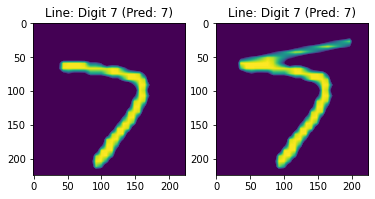

In [5]:
def calculate_L(model, img):
    lcl = model.features.lcl
    
    A = model.features.vgg19_unit(img.unsqueeze(0).to(model.device))
    K = lcl.K

    A = symmetric_padding(A, lcl.prd).repeat(1, lcl.n, 1, 1).to(model.device)
    padded_A = lcl.pad_activations(A)
    L = F.conv2d(padded_A, minmax_on_fm(K.transpose_(0, 1)), padding=0) / lcl.num_fm
    L = softmax_minmax_scaled(L)
    
    A_max = torch.sum((1 - lcl.iota) * A + lcl.iota * L, dim=(-2,-1))
    A_max = A_max.reshape((A_max.shape[0], lcl.n, A_max.shape[1] // lcl.n))
    A_max = torch.argmax(torch.transpose(A_max,2,1), dim=-1)

    # Get the argmax indices inside the multiplex cells for each sample in the batch
    fm_indices = A_max.shape[1] * A_max + torch.arange(0, A_max.shape[1]).to(model.device)
    
    A = torch.stack([torch.index_select(i, dim=0, index=j) for i,j in zip(A, fm_indices)])
    
    return L.cpu(), fm_indices.cpu(), A.cpu()
    
dataset_identity = load_mnistc(dirname='identity')
dataset_line = load_mnistc(dirname='line')
model = vgg19r_lcl5

img_index = 17
img, label = dataset_identity[img_index]
img2, label2 = dataset_line[img_index]

fig, axs = plt.subplots(1,2)
axs[0].imshow(img.transpose(1,2).transpose(0,2), vmin=0, vmax=1)
axs[0].set_title(f"Line: Digit {label} (Pred: {torch.argmax(model.forward(img.unsqueeze(0).to(model.device))).data})")
axs[1].imshow(img2.transpose(1,2).transpose(0,2), vmin=0, vmax=1)
axs[1].set_title(f"Line: Digit {label2} (Pred: {torch.argmax(model.forward(img2.unsqueeze(0).to(model.device))).data})")

L, idx, A = calculate_L(model, img)
L2, idx2, A2 = calculate_L(model, img2)

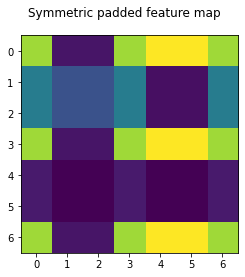

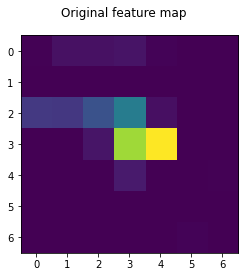

In [ ]:

def generate_feature_map_plot(img, topk=10, plot_scale=2):
    L, fm_idx, A = calculate_L(model, img)
    
    # TODO: Change to A once the reconstructed models have been retrained!
    A2 = model.features.vgg19_unit(img.unsqueeze(0).to(model.device))
    A2 = A2.repeat(1, model.features.lcl.n, 1, 1).cpu()

    plt.imshow(A[0, 405, ...].cpu(), vmin=0)
    plt.suptitle('Symmetric padded feature map', fontsize=1)
    plt.show()
    plt.imshow(A2[0, 405, ...].cpu(), vmin=0)
    plt.suptitle('Original feature map', fontsize=1)
    plt.show()
    
    filtered_L = torch.stack([torch.index_select(i, dim=0, index=j) for i,j in zip(L, fm_idx)])
    
    #topk_indices = torch.topk(torch.sum(filtered_L, dim=(-2,-1)), topk).indices[0]
    topk_indices = torch.topk(torch.sum(A, dim=(-2, -1)), topk).indices[0]
    
    fig, axs = plt.subplots(topk+1, topk+1, figsize=((topk+1)*plot_scale, (topk+1)*plot_scale))
    axs[0,0].axis('off')
    
    for k in range(topk):
        target_fm = topk_indices[k]
        axs[0, k+1].imshow(A2[0, target_fm, ...].cpu(), vmin=0)
        axs[0, k+1].set_title(f"FM: {target_fm}")

        axs[k+1, 0].imshow(A2[0, target_fm, ...].cpu(), vmin=0)
        axs[k+1, 0].set_title(f"FM: {target_fm}")

        for i in range(topk):
            source_fm = topk_indices[i]
            axs[i+1, k+1].imshow(model.features.lcl.K[source_fm, target_fm, ...].cpu())
            axs[i+1, k+1].set_title(f"S: {source_fm} -> T: {target_fm}")
                
    plt.tight_layout()
                
generate_feature_map_plot(img)

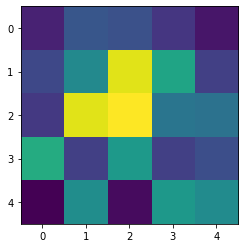

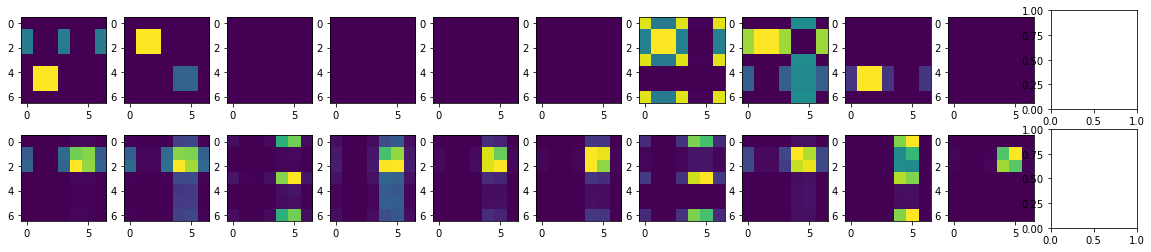

In [135]:
K = model.features.lcl.K
plt.imshow(K[0,4,:,:].cpu())
plt.show()

fig, axs = plt.subplots(2, 11, figsize=(20,4))

for i in range(10):
    axs[0, i].imshow(A[0,i,...].cpu(), vmin=0)
    axs[1, i].imshow(L[0,i,...].cpu(), vmin=0, vmax=1)


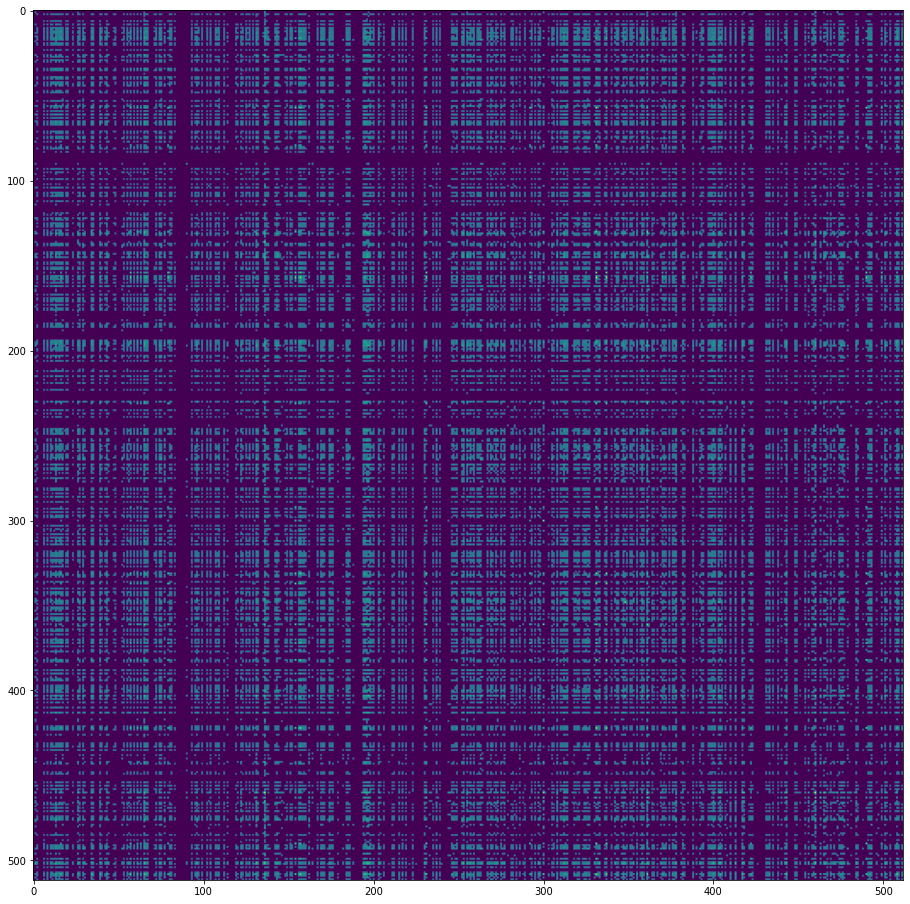

In [8]:
filtered_L = torch.stack([torch.index_select(i, dim=0, index=j) for i,j in zip(L, idx)])
filtered_L2 = torch.stack([torch.index_select(i, dim=0, index=j) for i,j in zip(L2, idx2)])

lvals = torch.sum(filtered_L.cpu(), dim=(-2,-1))[0,:]
lvals2 = torch.sum(filtered_L2.cpu(), dim=(-2,-1))[0,:]

product = torch.einsum('abcd, aecd -> be', filtered_L, filtered_L2)
plt.figure(figsize=(16,16))

x,y = torch.where(product < torch.quantile(product, 0.8))
product[x,y] = 0

plt.imshow(product, vmin=0, vmax=torch.max(product))

In [75]:
#processed = torch.zeros((10, 100, 2048, 7, 7))

def generate_indexes_for_dataset(dataset, min_samples=-1):
    label_indexes = dict()

    for i in range(10):
        label_indexes[i] = list()

    for i, (_, label) in enumerate(tqdm(iter(dataset), total=len(dataset))):
        label_indexes[int(label)].append(i)

    if min_samples > 0:
        for i in range(10):
            label_indexes[i] = np.random.choice(label_indexes[i], min_samples, replace=False)
            
    return label_indexes

identity_ids = generate_indexes_for_dataset(dataset_identity, 256)
#line_ids = generate_indexes_for_dataset(dataset_line, 1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [109]:
def generate_plot_data(dataset, ids):
    data = np.empty((len(ids.keys()), len(ids[0]), 2048))
    
    for d_id in tqdm(ids.keys(), desc='Digits'):
        for i, i_id in tqdm(enumerate(ids[d_id]), total=len(ids[d_id])):
            img, _ = dataset[i_id]

            L, fm_idx, A = calculate_L(model, img)

            fm_idx_all = np.zeros(2048)
            fm_idx_all[fm_idx] = 1

            data[d_id, i] = np.array(fm_idx_all)
    
    return data
        
x = generate_plot_data(dataset_identity, identity_ids)

Digits:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

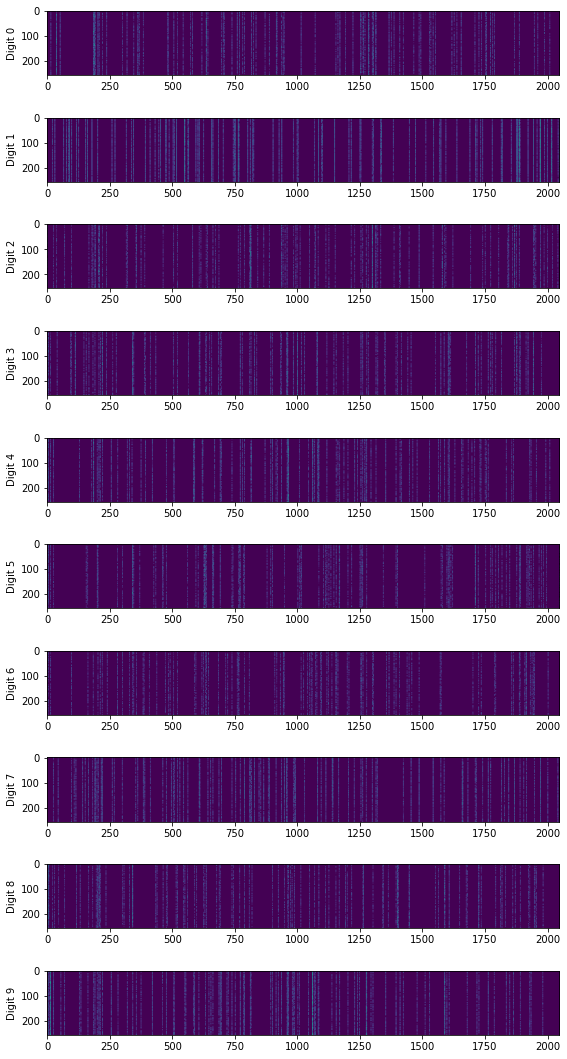

In [112]:
fig, axs = plt.subplots(10, 1, figsize=(8,15))

for d_id in range(x.shape[0]):
    tmp_data = np.copy(x[d_id])
    tmp_agg = np.sum(tmp_data, axis=0)
    tmp_data[:, np.where(tmp_agg <= np.percentile(tmp_agg, 95))] = 0
    
    axs[d_id].imshow(tmp_data, vmin=0, vmax=1)
    axs[d_id].set_ylabel(f"Digit {d_id}")
    
plt.tight_layout()